# Train an ingredient multi-label classification model using food_ingredients_dataset

#### install necessary library

In [6]:
!python.exe -m pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1


In [11]:
!pip install torch torchvision datasets scikit-learn pillow --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121, https://pypi.ngc.nvidia.com
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 114.9 MB/s eta 0:00:22
      --------------------------------------- 0.0/2.4 GB 116.2 MB/s eta 0:00:21
     - -------------------------------------- 0.1/2.4 GB 116.2 MB/s eta 0:00:21
     - -------------------------------------- 0.1/2.4 GB 118.4 MB/s eta 0:00:20
     -- ------------------------------------- 0.1/2.4 GB 117.9 MB/s eta 0:00:20
     -- ------------------------------------- 0.1/2.4 GB 117.5 MB/s eta 0:00:20
     -- ------------------------------------- 0.2/2.4 GB 117.3 MB/s eta 0:00:20
     --- ------------------------------------ 0.2/2.4 GB 118.3 MB/s eta 0:00:20
     --- ------------------------------------ 0.2/2.4 GB 118.0 MB/s eta 0:00:19
     ---- ----------------------------------- 0.3/2.4 GB 117.8 MB/s eta 0:00:19
     ---- -------------------------------

### download dataset

In [2]:
from datasets import load_dataset

ds = load_dataset("Scuccorese/food-ingredients-dataset")

D:\programs\MealMind\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### data preprocessing

In [3]:
from torchvision import transforms
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import DataLoader
import torch


# Convert the label format to a list for multi-label classification
def fix_format(example):
    if isinstance(example["ingredient"], str):
        example["ingredient"] = [example["ingredient"]]
    return example

# apply the fix_format function to each sample in the dataset ds.
ds = ds.map(fix_format)

"""
construct multi-label-binarizer.
the fit method learns all unique ingredient classes across the training data
and prepares the binarizer to convert those into a multi-hot encoded vector.
"""
mlb = MultiLabelBinarizer()
mlb.fit(ds["train"]["ingredient"])

# image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), #Resize the input image to 224*224 pixels (height x width). this is the standard input size for many CNN models.
    transforms.ToTensor(),  # Converts a PIL Image or NumPy array to a PyTorch Tensor and automatically changes the pixel value range from [0, 255] → [0.0, 1.0], also casts to float32. Shape becomes [C, H, W] (channel first). (C = 3 for RGB; Red, Green, Blue; H=224:Height; W=224:Width)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), #Pretrained models expect input images to be normalized using the same stats they were trained on. For example, ResNet or EfficientNet trained on ImageNet assume inputs are normalized with:This ensures faster convergence and better accuracy.These are the per-channel mean and standard deviation of pixel values for the ImageNet dataset, after converting images to [0.0, 1.0] float format using ToTensor().
])

# common preprocess function
def preprocess(example):
    image = example["image"]
    if image.mode != "RGB":
        image = image.convert("RGB")
    pixel_values = transform(image)
    labels = mlb.transform([example["ingredient"]])[0].astype("float32") # example["ingredient"] = ['egg', 'onion', 'tomato'] -> [[1, 1, 0]]
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }

# apply the preprocess function to each sample in the dataset ds.
ds = ds.map(preprocess)

# set data format
ds.set_format(type="torch", columns=["pixel_values", "labels"]) # convert pixel_values and labels to torch

# build DataLoader
train_loader = DataLoader(ds["train"], batch_size=32, shuffle=True) # PyTorch's utility for loading data in batches

In [4]:
print(mlb.classes_)  # print all ingredients labels

['adzuki beans' 'all-purpose flour' 'allspice' 'almond flour' 'amaranth'
 'apricot' 'arugula' 'asparagus' 'avocado' 'avocado oil' 'bamboo shoots'
 'banana' 'barley' 'beef' 'beet' 'beluga lentils' 'bergamot' 'bison'
 'black beans' 'black cherry' 'black lentils' 'black olives' 'black salt'
 'black sapote' 'black-eyed peas' 'blackberry' 'blueberry' 'bok choy'
 'boysenberry' 'bread flour' 'breadfruit' 'broccoli' 'broccoli stem'
 'brown lentils' 'brown sugar' 'brussels sprouts' 'buckwheat' 'buffalo'
 'bulgur' 'cabbage' 'cake flour' 'cane sugar' 'canned anchovies'
 'canned apples' 'canned apricots' 'canned artichoke hearts'
 'canned baked beans' 'canned beets' 'canned black beans'
 'canned cannellini beans' 'canned carrots' 'canned cherries'
 'canned chickpeas' 'canned clams' 'canned corn' 'canned crab'
 'canned fruit cocktail' 'canned green beans' 'canned kidney beans'
 'canned lima beans' 'canned lychee' 'canned mackerel'
 'canned mandarin oranges' 'canned mango' 'canned mushrooms'
 'canne

In [5]:
import joblib
joblib.dump(mlb, "../mlb.pkl")  # save a trained MultiLabelBinarizer to a file for future use. Use joblib.load("mlb.pkl") to load it.

['mlb.pkl']

### Train the classification model

In [23]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


### Define a multi-label image classification model using a pretrained ResNet-18

In [24]:
num_labels = len(mlb.classes_)

from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512), # project features to 512 dims
    nn.ReLU(),       # add non-linearity
    nn.Dropout(0.3), # prevent overfitting
    nn.Linear(512, num_labels), # final output layer# final output layer
    # nn.Sigmoid() # Required for BCELoss
)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### define the training logic

In [25]:
import torch.optim as optim

# ❗ Use BCEWithLogitsLoss for multi-label tasks (better than BCELoss + Sigmoid)
criterion = nn.BCEWithLogitsLoss() #loss=−[y⋅log(p)+(1−y)⋅log(1−p)]
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(20):
    model.train() # Set model to training mode (important for dropout/batchnorm)
    total_loss = 0

    for batch in train_loader:
        images = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad() # Clear previous gradients
        outputs = model(images) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backpropagation
        optimizer.step() # Update weights

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.0959
Epoch 2, Loss: 0.0215
Epoch 3, Loss: 0.0198
Epoch 4, Loss: 0.0178
Epoch 5, Loss: 0.0155
Epoch 6, Loss: 0.0129
Epoch 7, Loss: 0.0107
Epoch 8, Loss: 0.0086
Epoch 9, Loss: 0.0069
Epoch 10, Loss: 0.0054
Epoch 11, Loss: 0.0041
Epoch 12, Loss: 0.0032
Epoch 13, Loss: 0.0025
Epoch 14, Loss: 0.0019
Epoch 15, Loss: 0.0015
Epoch 16, Loss: 0.0013
Epoch 17, Loss: 0.0011
Epoch 18, Loss: 0.0010
Epoch 19, Loss: 0.0009
Epoch 20, Loss: 0.0008


#### Save the model

In [26]:
torch.save(model.state_dict(), "../ingredient_classifier.pt")

#### Load the model for inference

In [27]:
# Build the model architecture（keep it consistent）
model = models.resnet18(weights=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_labels),
    nn.Sigmoid()
)
model.load_state_dict(torch.load("../ingredient_classifier.pt", map_location=device, weights_only=True))
model.to(device)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Specifically, it affects:
| Layer Type  | Training Mode (`model.train()`) | Inference Mode (`model.eval()`)              |
| ----------- | ------------------------------- | -------------------------------------------- |
| `Dropout`   | Randomly drops neurons          | Turns **off** dropout (uses all units)       |
| `BatchNorm` | Uses **batch statistics**       | Uses **running (moving average) statistics** |


In [28]:
from PIL import Image
import torch
import joblib

# Load model and mlb
model.eval() #This sets the model to inference mode
mlb = joblib.load("../mlb.pkl")

def predict_ingredients(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)
    # disable gradient tracking to save memory and speed up
    with torch.no_grad():
        outputs = model(img_tensor)
        pred = outputs[0].cpu().numpy()

    threshold = 0.5
    pred_binary = (pred > threshold).astype(int).reshape(1, -1)
    pred_labels = mlb.inverse_transform(pred_binary)
    return pred_labels

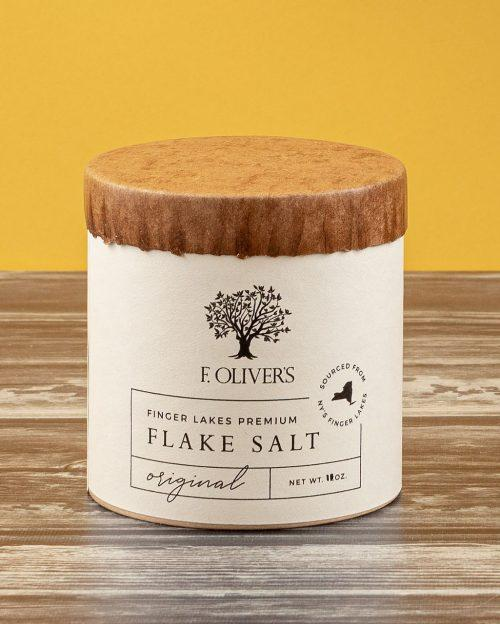

[('flaky salt',)]


In [29]:
from IPython.display import display
from PIL import Image

img_path = "../img.png"  # change to your own file path
img = Image.open(img_path)
display(img)

print(predict_ingredients(img_path))